# Install libraries

In [3]:
# !pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 31.0 MB/s eta 0:00:0000:0100:01


In [4]:
# !pip install --upgrade --force-reinstall tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 45.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 58.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
  Preparing me

In [5]:
# !wget "https://raw.githubusercontent.com/davidlainesv/TSSI-WLASL100/test/skeleton_graph.py" -O "skeleton_graph.py"

--2023-03-18 22:08:19--  https://raw.githubusercontent.com/davidlainesv/TSSI-WLASL100/test/skeleton_graph.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29633 (29K) [text/plain]
Saving to: ‘skeleton_graph.py’

skeleton_graph.py   100%[===================>]  28.94K  --.-KB/s    in 0.001s  

2023-03-18 22:08:19 (21.1 MB/s) - ‘skeleton_graph.py’ saved [29633/29633]



# Define util functions

Each video is loaded with the following function

In [8]:
import pandas as pd
import numpy as np

ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [9]:
import numpy as np
from mediapipe.python.solutions.pose import PoseLandmark
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from skeleton_graph import tssi_v2

tssi_order = tssi_v2()[1]
info_df = pd.read_csv("/kaggle/input/asl-signs/train.csv", index_col=0)
info_df = info_df.reset_index()

In [81]:
import tensorflow as tf
from mediapipe.python.solutions.pose import PoseLandmark


class Preprocessing:
    # original order = ['face', 'left_hand', 'pose', 'right_hand']
    
    range_dict = {
        'face': range(0, 468),
        'leftHand': range(468, 468+21),
        'pose': range(468+21, 468+21+33),
        'rightHand': range(468+21+33, 468+21+33+21),
        'root': range(468+21+33+21, 468+21+33+21+1)
    }

    slice_dict = {
        'face': slice(0, 468),
        'leftHand': slice(468, 468+21),
        'pose': slice(468+21, 468+21+33),
        'rightHand': slice(468+21+33, 468+21+33+21),
        'root': slice(468+21+33+21, 468+21+33+21+1)
    }

    def __init__(self, tssi_order):
        joints_idxs = []
        for joint in tssi_order:
            joint_type = joint.split("_")[0]
            if joint_type == "root":
                landmark_id = 0
            else:
                landmark_id = int(joint.split("_")[1])
            idx = self.range_dict[joint_type][landmark_id]
            joints_idxs.append(idx)
        self.joints_idxs = joints_idxs
        self.nose_idx = self.range_dict["pose"][PoseLandmark.NOSE]
        self.left_wrist_idx = self.range_dict["pose"][PoseLandmark.LEFT_WRIST]
        self.right_wrist_idx = self.range_dict["pose"][PoseLandmark.RIGHT_WRIST]
        self.root_idx = self.range_dict["root"][0]

    def __call__(self, keypoints):
        keypoints = self.fill_z_with_zeros(keypoints)
        keypoints = self.fill_nan_values(keypoints)
        keypoints = self.add_root(keypoints)
        keypoints = self.sort_columns(keypoints)
        return keypoints

    def fill_nan_values(self, keypoints):
        face = keypoints[:, self.slice_dict["face"], :]
        left_hand = keypoints[:, self.slice_dict["leftHand"], :]
        body = keypoints[:, self.slice_dict["pose"], :]
        right_hand = keypoints[:, self.slice_dict["rightHand"], :]

        nose = keypoints[:, self.nose_idx, :]
        nose = tf.expand_dims(nose, axis=1)
        left_wrist = keypoints[:, self.left_wrist_idx, :]
        left_wrist = tf.expand_dims(left_wrist, axis=1)
        right_wrist = keypoints[:, self.right_wrist_idx, :]
        right_wrist = tf.expand_dims(right_wrist, axis=1)

        left_hand = tf.where(
            tf.math.is_nan(left_hand),
            tf.experimental.numpy.full(tf.shape(left_hand), left_wrist),
            left_hand)
        right_hand = tf.where(
            tf.math.is_nan(right_hand),
            tf.experimental.numpy.full(tf.shape(right_hand), right_wrist),
            right_hand)
        face = tf.where(
            tf.math.is_nan(face),
            tf.experimental.numpy.full(tf.shape(face), nose),
            face)
        
        keypoints = tf.concat([face, left_hand, body, right_hand], axis=1)

        return keypoints

    def fill_z_with_zeros(self, keypoints):
        x, y, _ = tf.unstack(keypoints, axis=-1)
        zeros = tf.zeros(tf.shape(x), x.dtype)
        return tf.stack([x, y, zeros], axis=-1)

    def add_root(self, keypoints):
        left = keypoints[:, self.left_wrist_idx, :]
        right = keypoints[:, self.right_wrist_idx, :]
        root = (left + right) / 2
        root = tf.expand_dims(root, axis=1)
        keypoints = tf.concat([keypoints, root], axis=1)
        return keypoints

    def sort_columns(self, keypoints):
        keypoints = tf.gather(keypoints, indices=self.joints_idxs, axis=1)
        return keypoints


In [82]:
from pathlib import Path

source_path = Path("/kaggle/input/asl-signs")
filepath = source_path / info_df["path"][0]

(23, 543, 3) => (23, 135, 3)
True => False


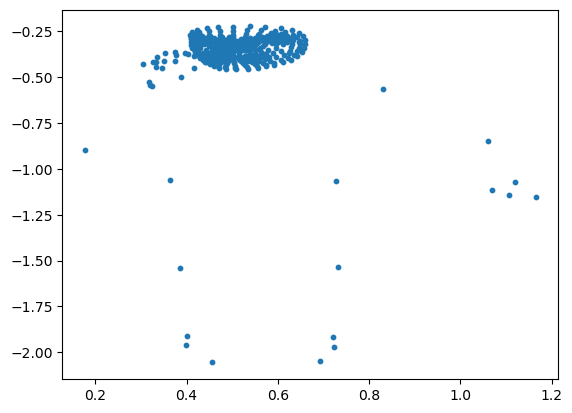

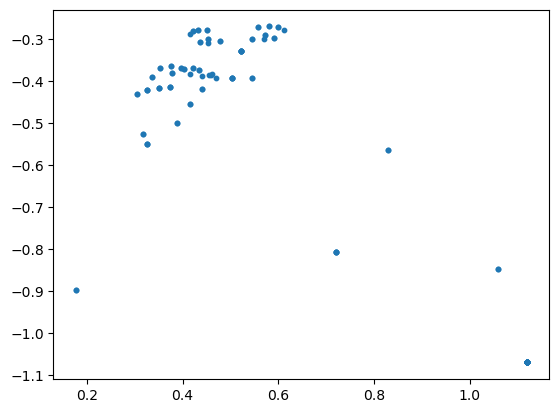

In [104]:
import matplotlib.pyplot as plt

frame_idx = 1
preprocessing_layer = Preprocessing(tssi_order)

keypoints = load_relevant_data_subset(filepath)
filt_keypoints = preprocessing_layer(keypoints).numpy()

print(keypoints.shape, "=>", filt_keypoints.shape)
print(np.isnan(keypoints).any(), "=>", np.isnan(filt_keypoints).any())

plt.figure()
plt.scatter(keypoints[frame_idx, :, 0], -keypoints[frame_idx, :, 1], s=10)

plt.figure()
plt.scatter(filt_keypoints[frame_idx, :, 0], -filt_keypoints[frame_idx, :, 1], s=10)

In [117]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

info_df = pd.read_csv("/kaggle/input/asl-signs/train.csv", index_col=0)
info_df = info_df.reset_index()


def get_split(info_df, split):
    sss = StratifiedShuffleSplit(n_splits=1,
                                 test_size=0.2,
                                 random_state=0)
    filenames = info_df["path"]
    labels = info_df["sign"]
    splits = list(sss.split(filenames, labels))
    train_indices, test_indices = splits[0]
    if split == "train":
        filenames = info_df.loc[train_indices, "path"]
        labels = info_df.loc[train_indices, "sign"]
    else:
        filenames = info_df.loc[test_indices, "path"]
        labels = info_df.loc[test_indices, "sign"]
    return zip(filenames, labels)


def get_cv_split(info_df, split, cv_split):
    skf = StratifiedKFold(n_splits=5,
                          random_state=0,
                          shuffle=True)
    filenames = info_df["path"]
    labels = info_df["sign"]
    splits = list(skf.split(filenames, labels))
    train_indices, test_indices = splits[cv_split-1]
    if split == "train":
        filenames = info_df.loc[train_indices, "path"]
        labels = info_df.loc[train_indices, "sign"]
    else:
        filenames = info_df.loc[test_indices, "path"]
        labels = info_df.loc[test_indices, "sign"]
    return zip(filenames, labels)


def generate_examples(source_path, split, cv_split=None):
    """Generator of examples for each split."""

    if cv_split is None:
        examples = get_split(info_df, split)
    else:
        examples = get_cv_split(info_df, split, cv_split-1)

    for filename, label in examples:
        filepath = source_path / filename
        data = load_relevant_data_subset(filepath)
        data = preprocessing_layer.fill_nan_values(data)

        # Yields (key, example)
        yield filename, {
            'pose': data.numpy(),
            'label': label
        }


# Generate dataset

In [118]:
from pathlib import Path

extracted_path = Path("/kaggle/input/asl-signs")

In [122]:
!rm -r "/kaggle/working/datasets"

In [123]:
import numpy as np
import tensorflow_datasets as tfds

tfds.dataset_builders.store_as_tfds_dataset(
    name="popsign",
    version=tfds.core.Version('1.0.0'),
    release_notes = { '1.0.0': 'Initial release.' },
    data_dir="/kaggle/working/datasets",
    split_datasets={
        "train": generate_examples(extracted_path, 'train'),
        "validation": generate_examples(extracted_path, 'validation'),
    },
    features=tfds.features.FeaturesDict({
        'pose': tfds.features.Tensor(shape=(None, ROWS_PER_FRAME, 3), dtype=np.float32),
        'label': tfds.features.ClassLabel(names=info_df["sign"].unique().tolist())
    })
)

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /kaggle/working/datasets/popsign/1.0.0.incomplete561WBD/popsign-train.tfrecord*...:   0%|          |…

Generating validation examples...: 0 examples [00:00, ? examples/s]

ResourceExhaustedError: /kaggle/working/datasets/popsign/1.0.0.incomplete561WBD/bucket_065d51f4-3e4d-428c-895a-21404012786f_259.tmp; No space left on device

In [ ]:
ds, info = tfds.load('popsign', data_dir="datasets", with_info=True)

In [ ]:
ds["train"].cardinality()

In [ ]:
ds["validation"].cardinality()

In [ ]:
!zip -r popsign.zip "/kaggle/working/datasets/popsign"

In [ ]:
!rm popsign.zip

In [ ]:
!zip -r popsign.zip /kaggle/working/datasets/popsign